In [1]:
%matplotlib inline
import sys

import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats

import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import models, transforms

In [2]:
DATA_ROOT = '/mnt/ssd/data/HAM10000'

df = pd.read_csv(f'{DATA_ROOT}/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df['path'] = df['image_id'].apply(lambda fname: f'{DATA_ROOT}/images/{fname}.jpg')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/mnt/ssd/data/HAM10000/images/ISIC_0031633.jpg


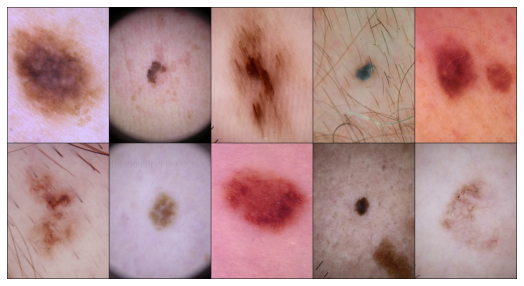

In [4]:
samples = df['path'].sample(10)
images = [transforms.ToTensor()(Image.open(path)) for path in samples]
grid = make_grid(images, nrow=2)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.imshow(grid.permute(2, 1, 0))
plt.axis('off')
plt.grid(False)

In [5]:
lesion_types = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

one_hot_labels = {k: i for i, k in enumerate(lesion_types.keys())}
print(one_hot_labels)
df['label'] = df['dx'].map(one_hot_labels)
df.head()

{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0027419.jpg,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0025030.jpg,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0026769.jpg,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/mnt/ssd/data/HAM10000/images/ISIC_0025661.jpg,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/mnt/ssd/data/HAM10000/images/ISIC_0031633.jpg,2


/home/malte/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


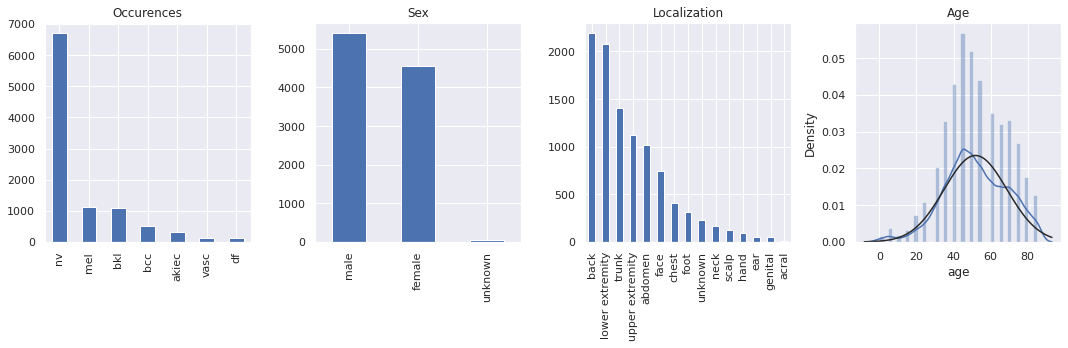

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15,5))
df['dx'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Occurences')
df['sex'].value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Sex')
df['localization'].value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('Localization')
sns.distplot(df['age'], fit=stats.norm);
axs[3].set_title('Age')
plt.tight_layout()

In [7]:
occurences = df['dx'].value_counts()
occurences

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [8]:
reweighting = [np.median(occurences) / v for v in occurences]
reweighting

[0.07665920954511558,
 0.4618149146451033,
 0.467697907188353,
 1.0,
 1.5718654434250765,
 3.619718309859155,
 4.469565217391304]

In [9]:
class SkinCancerDataset(object):
    
    def __init__(self, df: pd.DataFrame, transform: object = None):
        self.df = df.reset_index()
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> (Tensor):
        X = Image.open(self.df['path'][idx])
        y = torch.tensor(int(self.df['label'][idx]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [20]:
amounts = {'train': 0.7, 'val': 0.1, 'test': 0.2}
idxs = {'train': [], 'val': [], 'test': []}
no_samples = len(df)

for label, no_sanples in occurences.items():
    class_idx = np.array(list(df[df['dx'] == label].index))
    np.random.shuffle(class_idx)
    
    for train_type, amount in amounts.items():
        _idx = class_idx[:int(no_samples * amount)]
        idxs[train_type] += _idx.tolist()
        np.delete(class_idx, np.arange(len(_idx)))

In [27]:
LR = 1e-3
WEIGHT_DECAY = 1e-4
N_CLASSES = len(one_hot_labels)
N_EPOCHS = 10
BATCH_SIZE = 32
INPUT_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)

transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_set = SkinCancerDataset(df.iloc[idxs['train']], transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_set = SkinCancerDataset(df.iloc[idxs['val']], transform=transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_set = SkinCancerDataset(df.iloc[idxs['test']], transform=transform)
test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


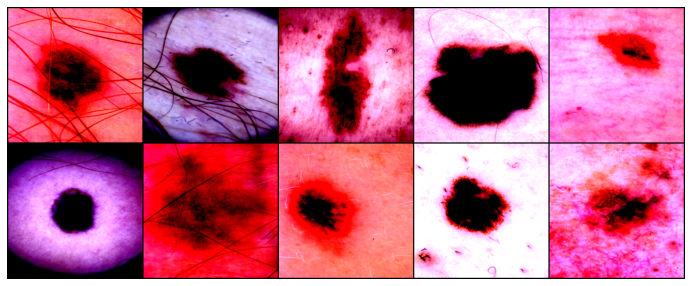

In [29]:
images = [train_set[i][0] for i in range(10)]
grid = make_grid(images, nrow=2)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.imshow(grid.permute(2, 1, 0))
plt.axis('off')
plt.grid(False)

In [30]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, N_CLASSES)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)#, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(reweighting)).to(DEVICE)

In [31]:
def validate(data_loader: object, model: nn.Module, device: str = 'cuda') -> float:
    pbar = tqdm(data_loader, file=sys.stdout)
    with torch.no_grad():
        accs = []
        for i, (inputs, target) in enumerate(pbar):
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            prediction = outputs.detach().argmax(dim=1)
            acc = (prediction == target).sum() / len(prediction)
            accs.append(acc.item())
            
            pbar.set_description(f'Acc: {acc}')

        acc = np.mean(accs)
    return acc

In [32]:
accs = {'train': [], 'val': []}

for e in range(N_EPOCHS):
    pbar = tqdm(train_loader, file=sys.stdout)
    train_accs = []
    for i, (inputs, target) in enumerate(pbar):

        inputs, target = inputs.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        prediction = outputs.detach().argmax(dim=1)
        acc = (prediction == target).sum() / len(prediction)
        train_accs.append(acc.item())

        pbar.set_description(f'Epoch: {e}/{N_EPOCHS} | Loss: {loss.item()} | Acc: {acc.item()}')
    train_acc = np.mean(train_accs)
    accs['train'].append(train_acc)
    
    val_acc = validate(val_loader, model, DEVICE)
    print(f'Train Acc: {train_acc} | Val Acc: {val_acc}')
    accs['val'].append(val_acc)

Epoch: 0/10 | Loss: 1.554201602935791 | Acc: 0.35483869910240173: 100%|██████████| 313/313 [00:40<00:00,  7.80it/s]
Acc: 0.0: 100%|██████████| 129/129 [00:08<00:00, 14.53it/s]    
Train Acc: 0.42894916517285114 | Val Acc: 0.25169573643410853
Epoch: 1/10 | Loss: 1.7123812437057495 | Acc: 0.4193548262119293: 100%|██████████| 313/313 [00:40<00:00,  7.67it/s]
Acc: 0.20000000298023224: 100%|██████████| 129/129 [00:08<00:00, 14.65it/s]
Train Acc: 0.4869627949719231 | Val Acc: 0.2326550387827925
Epoch: 2/10 | Loss: 1.3203070163726807 | Acc: 0.4193548262119293: 100%|██████████| 313/313 [00:40<00:00,  7.64it/s]
Acc: 0.0: 100%|██████████| 129/129 [00:08<00:00, 14.56it/s]    
Train Acc: 0.49924314640962275 | Val Acc: 0.25799418604651164
Epoch: 3/10 | Loss: 1.0477466583251953 | Acc: 0.6451612710952759: 100%|██████████| 313/313 [00:41<00:00,  7.60it/s]
Acc: 0.0: 100%|██████████| 129/129 [00:08<00:00, 14.61it/s]    
Train Acc: 0.5333112181185152 | Val Acc: 0.27785852713178294
Epoch: 4/10 | Loss: 1.1

In [33]:
test_acc = validate(test_loader, model, DEVICE)
print(f'Test Acc: {test_acc}')

Acc: 0.0: 100%|██████████| 129/129 [00:08<00:00, 14.77it/s]    
Test Acc: 0.2853682170542636


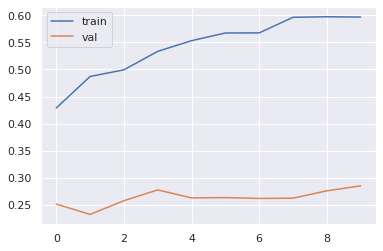

In [34]:
fig, ax = plt.subplots()
for label, values in accs.items():
    ax.plot(values, label=label)
ax.legend()

In [35]:
data_set = SkinCancerDataset(df, transform=transform)
data_loader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

confusion_matrix = torch.zeros((len(occurences), len(occurences)))

pbar = tqdm(data_loader, file=sys.stdout)
with torch.no_grad():
    for i, (inputs, target) in enumerate(pbar):
        inputs, target = inputs.to(DEVICE), target.to(DEVICE)
        outputs = model(inputs)
        prediction = outputs.detach().argmax(dim=1)
        
        confusion_matrix[target, prediction] += 1

100%|██████████| 313/313 [00:20<00:00, 15.03it/s]


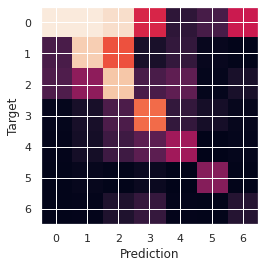

In [36]:
fg, ax = plt.subplots()
ax.imshow(confusion_matrix)
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xlabel('Prediction')
ax.set_ylabel('Target')
plt.show()